In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Nov  5 09:59:34 2019

@author: nathanblock
"""



import numpy as np
import csv
import string
import sys
import re
import spacy

csv.field_size_limit(sys.maxsize)



#from string import maketrans

articles = []

sources = {"New York Times", "Breitbart", "CNN", "Business Insider", "The Atlantic", "Fox News", "Talking Points Memo", "Buzzfeed News", "National Review", "New York Post", "The Guardian", "NPR", "Reuters", "Vox","The Washington Post"}


with open('all-the-news/articles1.csv', newline='') as csvfile:
   reader = csv.reader(csvfile, delimiter=',', quotechar='"')
   categories = csvfile.readline()   # skip the first line
   for i, line in enumerate(reader):
       articles.append(line)
       
with open('all-the-news/articles2.csv', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',', quotechar='"')
    categories = csvfile.readline()   # skip the first line
    for i, line in enumerate(reader):
        articles.append(line)

with open('all-the-news/articles3.csv', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',', quotechar='"')
    categories = csvfile.readline()   # skip the first line
    for i, line in enumerate(reader):
        articles.append(line)


for i, article in enumerate(articles):
    if not article[9]:
        articles.remove(article)
    
    
shortened_articles = articles[0:260]
print(articles[0][3])
for i, article in enumerate(articles):
    if(i == len(articles) - 2):
        break
    if(articles[i][3] != articles[i+1][3]):
        shortened_articles.extend(articles[i+1:i+261])
        print(articles[i + 1][3])


nlp = spacy.load('en', disable=['parser', 'ner'])




# put all the words in the article together bc they get split by commas in the csvread
for i, shortened_article in enumerate(shortened_articles):
    #Lemmatization
    doc = nlp(shortened_article[9])
    shortened_article[9] = " ".join([token.lemma_ for token in doc])
    shortened_article[9] = shortened_article[9].replace('-PRON- ', '')
    #article[9] += article[9+j]
    #remove all punctuation from the articles
    shortened_article[9] = re.sub(r'[^a-zA-Z]', " ", shortened_article[9].lower())
        #print(shortened_article[9])
    shortened_articles[i] = shortened_article[0:10]



PGoutput = shortened_articles[0:10]
TRoutput = shortened_articles[10:210]
TEoutput = shortened_articles[210:260]
print(shortened_articles[1][3])
#gather playground data
for i in range(1,15):
    index = i * 260
    PGoutput.extend(shortened_articles[index:index+10])
    TRoutput.extend(shortened_articles[index+10:index+210])
    TEoutput.extend(shortened_articles[index+210:index+260])
    #print(shortened_articles[i+1][3])


with open('playground_dataset.csv', 'w', newline='') as csvfile:
    outwriter = csv.writer(csvfile, delimiter=',', quoting=csv.QUOTE_MINIMAL)
    for i in PGoutput:
        outwriter.writerow(i)
    
with open('train_dataset.csv', 'w', newline='') as csvfile:
    outwriter = csv.writer(csvfile, delimiter=',', quoting=csv.QUOTE_MINIMAL)
    for i in TRoutput:
        outwriter.writerow(i)
        
with open('test_dataset.csv', 'w', newline='') as csvfile:
    outwriter = csv.writer(csvfile, delimiter=',', quoting=csv.QUOTE_MINIMAL)
    for i in TEoutput:
        outwriter.writerow(i)
        
        
#glove vector code
file1 = open("vectors.txt","r")
Dict = {} 
for line in file1:
    line = line.split()
    Dict[line[0]] = np.array((line[1:])).astype(float)
file1.close()

New York Times
Breitbart
CNN
Business Insider
Atlantic
Fox News
Talking Points Memo
Buzzfeed News
National Review
New York Post
Guardian
NPR
Reuters
Vox
Washington Post
New York Times


In [3]:
# read in train and test csv's as pandas.DataFrame's
# pre-process the article titles in the same way as the article text

import pandas as pd

data_train = pd.read_csv('train_dataset.csv', sep=',', header=None).drop(labels=0, axis='columns')
#data_train.head(3)
data_train.columns = ['id', 'title', 'publication', 'author', 'date', 'year', 'month', 'url', 'content']
#data_train.head(3)

data_test = pd.read_csv('test_dataset.csv', sep=',', header=None).drop(labels=0, axis='columns')
data_test.columns = ['id', 'title', 'publication', 'author', 'date', 'year', 'month', 'url', 'content']
#data_test.head(3)

print(data_test['title'][0])
print(len(data_train))

# same pre-processing for title as article in case it is included in TF-IDF/LSA
for i in range(len(data_train)):
    #Lemmatization
    doc = nlp(data_train.loc[i, 'title'])
    new_title = " ".join([token.lemma_ for token in doc])
    new_title = new_title.replace('-PRON- ', '')
    new_title = re.sub(r'[^a-zA-Z]', " ", new_title.lower())
    data_train.loc[i, 'title'] = new_title
for i in range(len(data_test)):
    #Lemmatization
    doc = nlp(data_test.loc[i, 'title'])
    new_title = " ".join([token.lemma_ for token in doc])
    new_title = new_title.replace('-PRON- ', '')
    new_title = re.sub(r'[^a-zA-Z]', " ", new_title.lower())
    data_test.loc[i, 'title'] = new_title

Republicans, Facing Pressure, Delay Hearings for 4 Trump Cabinet Nominees - The New York Times
3000


In [4]:
# get just the relevant data for our problem: title, content, publication
content_data_train = data_train[['title', 'content', 'publication']]
content_data_test = data_test[['title', 'content', 'publication']]
content_title_data_train = pd.DataFrame(columns=['content', 'publication'])
content_title_data_test = pd.DataFrame(columns=['content', 'publication'])

# merge content and title into one document
for i in range(len(content_data_train)):
    content_title_data_train.loc[i, 'publication'] = content_data_train.loc[i, 'publication']
    # article titles often have '- Publication' at the end of the title - remove this bc too big a hint
    # (slightly stupid right now because it leaves the 'the' in 'the new york times')
    corrected_title = re.sub((content_data_train.loc[i, 'publication']).lower(), '', content_data_train.loc[i, 'title'])
    content_title_data_train.loc[i, 'content'] = corrected_title + ' ' + content_data_train.loc[i, 'content']
for i in range(len(content_data_test)):
    content_title_data_test.loc[i, 'publication'] = content_data_test.loc[i, 'publication']
    # article titles often have '- Publication' at the end of the title - remove this bc too big a hint
    corrected_title = re.sub((content_data_test.loc[i, 'publication']).lower(), '', content_data_test.loc[i, 'title'])
    content_title_data_test.loc[i, 'content'] = corrected_title + ' ' + content_data_test.loc[i, 'content']
#content_data_train.head()

In [5]:
# get train and test sets
X_train = {'content' : content_data_train.loc[:, 'content'], 'title' : content_title_data_train.loc[:, 'content']}
X_test = {'content' : content_data_test.loc[:, 'content'], 'title' : content_title_data_test.loc[:, 'content']}
unique_publications = list(set(content_data_train.loc[:, 'publication']))
label_dict = {}
for i in range(len(unique_publications)):
    label_dict[unique_publications[i]] = i
y_train = {'content': [label_dict[pub] for pub in content_data_train.loc[:, 'publication']], 'title': [label_dict[pub] for pub in content_title_data_train.loc[:, 'publication']]}
y_test = {'content': [label_dict[pub] for pub in content_data_test.loc[:, 'publication']], 'title': [label_dict[pub] for pub in content_title_data_test.loc[:, 'publication']]}

In [30]:
# get tf-idf vectorizers (we want to tune max_df, so we try values in [0.25, 0.5, 1.])
# we also want to tune the largest n-grams considered, so 
from sklearn.feature_extraction.text import TfidfVectorizer

max_dfs = [0.25, 0.5, 1.]
max_ngram = [1, 2, 3]

vectorizers = {}
for max_n in max_ngram:
    vectorizers[max_n] = {'content': [], 'title': []}
    
    for max_df in max_dfs:
        vectorizers[max_n]['content'].append(TfidfVectorizer(max_df=max_df, min_df=10, stop_words='english', ngram_range=(1,max_n)))
        vectorizers[max_n]['title'].append(TfidfVectorizer(max_df=max_df, min_df=10, stop_words='english', ngram_range=(1,max_n)))
#print(len(vectorizers))

# get term-document matrices (entries are tf-idf for each word) for train and test set
X_train_tfidf = {}
for max_n in max_ngram:
    X_train_tfidf[max_n] = {}
    for k, v in X_train.items():
        X_train_tfidf[max_n][k] = []
        for i in range(len(max_dfs)):
            X_train_tfidf[max_n][k].append(vectorizers[max_n][k][i].fit_transform(X_train[k]))
            print('n_grams ', max_n, ' training ', k, ' max_df ', max_dfs[i], ' done')
        
X_test_tfidf = {}
for max_n in max_ngram:
    X_test_tfidf[max_n] = {}
    for k, v in X_test.items():
        X_test_tfidf[max_n][k] = []
        for i in range(len(max_dfs)):
            X_test_tfidf[max_n][k].append(vectorizers[max_n][k][i].transform(X_test[k]))
            print('n_grams ', max_n, ' test ', k, ' max_df ', max_dfs[i], ' done')

n_grams  1  training  content  max_df  0.25  done
n_grams  1  training  content  max_df  0.5  done
n_grams  1  training  content  max_df  1.0  done
n_grams  1  training  title  max_df  0.25  done
n_grams  1  training  title  max_df  0.5  done
n_grams  1  training  title  max_df  1.0  done
n_grams  2  training  content  max_df  0.25  done
n_grams  2  training  content  max_df  0.5  done
n_grams  2  training  content  max_df  1.0  done
n_grams  2  training  title  max_df  0.25  done
n_grams  2  training  title  max_df  0.5  done
n_grams  2  training  title  max_df  1.0  done
n_grams  3  training  content  max_df  0.25  done
n_grams  3  training  content  max_df  0.5  done
n_grams  3  training  content  max_df  1.0  done
n_grams  3  training  title  max_df  0.25  done
n_grams  3  training  title  max_df  0.5  done
n_grams  3  training  title  max_df  1.0  done
n_grams  1  test  content  max_df  0.25  done
n_grams  1  test  content  max_df  0.5  done
n_grams  1  test  content  max_df  1.0 

750
1.0000000000000002


[Text(0, 0.5, 'nth singular value'),
 Text(0.5, 0, 'n'),
 Text(0.5, 1.0, 'singular values of term-document matrix\ncontent, max_df=0.250000, 1-grams')]

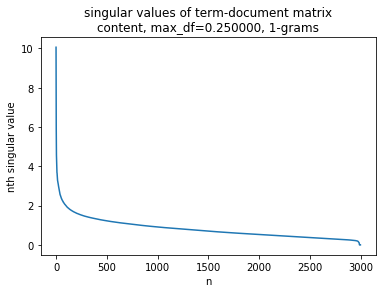

In [31]:
from sklearn.decomposition import TruncatedSVD
import matplotlib
import matplotlib.pyplot as plt

# 1-grams, content, max_df=0.25
# experiment with a good reduced rank to find one that explains most of the variance in the term-document matrices
X_train_tfidf[1]['content'][0]
print(len(X_test['content']))

# plot the singular values (scree plot) to find a knee that suggests underlying low rank structure
rank = 2999
svd = TruncatedSVD(rank)
svd.fit(X_train_tfidf[1]['content'][0])
print(svd.explained_variance_ratio_.sum())
fig, ax = plt.subplots()
ax.plot(svd.singular_values_)
ax.set(xlabel='n', ylabel='nth singular value', title = ('singular values of term-document matrix\ncontent, max_df=%f, %d-grams' % (max_dfs[0], 1)))

In [32]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

rank = 1000
svd = TruncatedSVD(rank)
svd.fit(X_train_tfidf[1]['content'][0])
print(svd.explained_variance_ratio_.sum())

# dictionary of TruncatedSVD transforms
lsa = {}
lsa[1] = {}
lsa[1]['content'] = []
(lsa[1]['content']).append(make_pipeline(svd, Normalizer(copy=False)))

# dictionary of tf-idf training data after TruncatedSVD transform
X_train_lsa = {}
X_train_lsa[1] = {}
X_train_lsa[1]['content'] = []
(X_train_lsa[1]['content']).append(lsa[1]['content'][0].fit_transform(X_train_tfidf[1]['content'][0]))

# dictionary of tf-idf test data after TruncatedSVD transfrom (transform was learned from training data)
X_test_lsa = {}
X_test_lsa[1] = {}
X_test_lsa[1]['content'] = []
(X_test_lsa[1]['content']).append(lsa[1]['content'][0].transform(X_test_tfidf[1]['content'][0]))

0.7695062260238197


1.0000000000000002


[Text(0, 0.5, 'nth singular value'),
 Text(0.5, 0, 'n'),
 Text(0.5, 1.0, 'singular values of term-document matrix\ncontent, max_df=0.250000, 2-grams')]

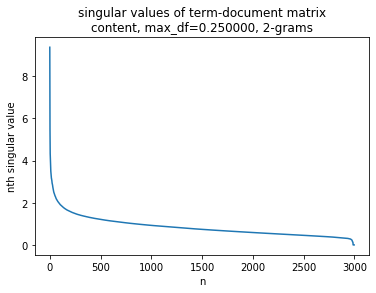

In [33]:
# experiment with a good reduced rank to find one that explains most of the variance in the term-document matrices
X_train_tfidf[2]['content'][0]

# 2-grams, content, max_df=0.25
# plot the singular values (scree plot) to find a knee that suggests underlying low rank structure
rank = 2999
svd = TruncatedSVD(rank)
svd.fit(X_train_tfidf[2]['content'][0])
print(svd.explained_variance_ratio_.sum())
fig, ax = plt.subplots()
ax.plot(svd.singular_values_)
ax.set(xlabel='n', ylabel='nth singular value', title = ('singular values of term-document matrix\ncontent, max_df=%f, %d-grams' % (max_dfs[0], 2)))

In [34]:
rank = 1050
svd = TruncatedSVD(rank)
svd.fit(X_train_tfidf[2]['content'][0])
print(svd.explained_variance_ratio_.sum())

# dictionary of TruncatedSVD transforms
lsa[2] = {}
lsa[2]['content'] = []
(lsa[2]['content']).append(make_pipeline(svd, Normalizer(copy=False)))

# dictionary of tf-idf training data after TruncatedSVD transform
X_train_lsa[2] = {}
X_train_lsa[2]['content'] = []
(X_train_lsa[2]['content']).append(lsa[2]['content'][0].fit_transform(X_train_tfidf[2]['content'][0]))

# dictionary of tf-idf test data after TruncatedSVD transfrom (transform was learned from training data)
X_test_lsa[2] = {}
X_test_lsa[2]['content'] = []
(X_test_lsa[2]['content']).append(lsa[2]['content'][0].transform(X_test_tfidf[2]['content'][0]))

0.7470377480267556


1.0


[Text(0, 0.5, 'nth singular value'),
 Text(0.5, 0, 'n'),
 Text(0.5, 1.0, 'singular values of term-document matrix\ncontent, max_df=0.250000, 3-grams')]

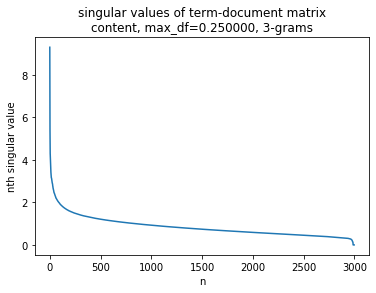

In [35]:
# experiment with a good reduced rank to find one that explains most of the variance in the term-document matrices
X_train_tfidf[3]['content'][0]

# 3-grams, content, max_df=0.25
# plot the singular values (scree plot) to find a knee that suggests underlying low rank structure
rank = 2999
svd = TruncatedSVD(rank)
svd.fit(X_train_tfidf[3]['content'][0])
print(svd.explained_variance_ratio_.sum())
fig, ax = plt.subplots()
ax.plot(svd.singular_values_)
ax.set(xlabel='n', ylabel='nth singular value', title = ('singular values of term-document matrix\ncontent, max_df=%f, %d-grams' % (max_dfs[0], 3)))

In [36]:
rank = 1060
svd = TruncatedSVD(rank)
svd.fit(X_train_tfidf[3]['content'][0])
print(svd.explained_variance_ratio_.sum())

# dictionary of TruncatedSVD transforms
lsa[3] = {}
lsa[3]['content'] = []
(lsa[3]['content']).append(make_pipeline(svd, Normalizer(copy=False)))

# dictionary of tf-idf training data after TruncatedSVD transform
X_train_lsa[3] = {}
X_train_lsa[3]['content'] = []
(X_train_lsa[3]['content']).append(lsa[3]['content'][0].fit_transform(X_train_tfidf[3]['content'][0]))

# dictionary of tf-idf test data after TruncatedSVD transfrom (transform was learned from training data)
X_test_lsa[3] = {}
X_test_lsa[3]['content'] = []
(X_test_lsa[3]['content']).append(lsa[3]['content'][0].transform(X_test_tfidf[3]['content'][0]))

0.7488507932520769


1.0000000000000002


[Text(0, 0.5, 'nth singular value'),
 Text(0.5, 0, 'n'),
 Text(0.5, 1.0, 'singular values of term-document matrix\ncontent, max_df=0.500000, 1-grams')]

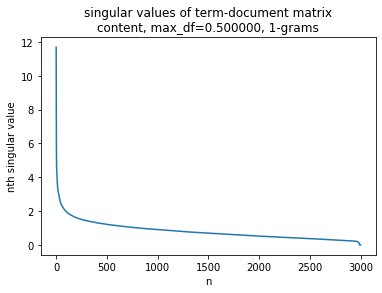

In [37]:
# 1-grams, content, max_df=0.5
# experiment with a good reduced rank to find one that explains most of the variance in the term-document matrices
X_train_tfidf[1]['content'][1]

# plot the singular values (scree plot) to find a knee that suggests underlying low rank structure
rank = 2999
svd = TruncatedSVD(rank)
svd.fit(X_train_tfidf[1]['content'][1])
print(svd.explained_variance_ratio_.sum())
fig, ax = plt.subplots()
ax.plot(svd.singular_values_)
ax.set(xlabel='n', ylabel='nth singular value', title = ('singular values of term-document matrix\ncontent, max_df=%f, %d-grams' % (max_dfs[1], 1)))

In [38]:
# 1000 also seems reasonable for this given scree plot
rank = 1000
svd = TruncatedSVD(rank)
svd.fit(X_train_tfidf[1]['content'][1])
print(svd.explained_variance_ratio_.sum())

# dictionary of TruncatedSVD transforms
(lsa[1]['content']).append(make_pipeline(svd, Normalizer(copy=False)))

# dictionary of tf-idf training data after TruncatedSVD transform
(X_train_lsa[1]['content']).append(lsa[1]['content'][1].fit_transform(X_train_tfidf[1]['content'][1]))

# dictionary of tf-idf test data after TruncatedSVD transfrom (transform was learned from training data)
(X_test_lsa[1]['content']).append(lsa[1]['content'][1].transform(X_test_tfidf[1]['content'][1]))

0.7736274486499696


1.0000000000000002


[Text(0, 0.5, 'nth singular value'),
 Text(0.5, 0, 'n'),
 Text(0.5, 1.0, 'singular values of term-document matrix\ncontent, max_df=0.500000, 2-grams')]

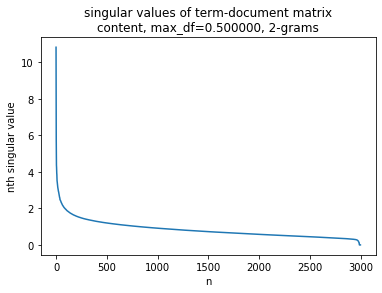

In [39]:
# 2-grams, content, max_df=0.5
# experiment with a good reduced rank to find one that explains most of the variance in the term-document matrices
X_train_tfidf[2]['content'][1]

# plot the singular values (scree plot) to find a knee that suggests underlying low rank structure
rank = 2999
svd = TruncatedSVD(rank)
svd.fit(X_train_tfidf[2]['content'][1])
print(svd.explained_variance_ratio_.sum())
fig, ax = plt.subplots()
ax.plot(svd.singular_values_)
ax.set(xlabel='n', ylabel='nth singular value', title = ('singular values of term-document matrix\ncontent, max_df=%f, %d-grams' % (max_dfs[1], 2)))

In [40]:
# 1000 also seems reasonable for this given scree plot
rank = 1050
svd = TruncatedSVD(rank)
svd.fit(X_train_tfidf[2]['content'][1])
print(svd.explained_variance_ratio_.sum())

# dictionary of TruncatedSVD transforms
(lsa[2]['content']).append(make_pipeline(svd, Normalizer(copy=False)))

# dictionary of tf-idf training data after TruncatedSVD transform
(X_train_lsa[2]['content']).append(lsa[2]['content'][1].fit_transform(X_train_tfidf[2]['content'][1]))

# dictionary of tf-idf test data after TruncatedSVD transfrom (transform was learned from training data)
(X_test_lsa[2]['content']).append(lsa[2]['content'][1].transform(X_test_tfidf[2]['content'][1]))

0.751985980682936


1.0


[Text(0, 0.5, 'nth singular value'),
 Text(0.5, 0, 'n'),
 Text(0.5, 1.0, 'singular values of term-document matrix\ncontent, max_df=0.500000, 3-grams')]

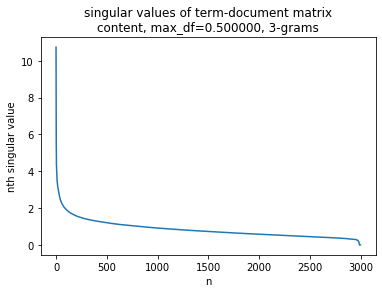

In [41]:
# 3-grams, content, max_df=0.5
# experiment with a good reduced rank to find one that explains most of the variance in the term-document matrices
X_train_tfidf[3]['content'][1]

# plot the singular values (scree plot) to find a knee that suggests underlying low rank structure
rank = 2999
svd = TruncatedSVD(rank)
svd.fit(X_train_tfidf[3]['content'][1])
print(svd.explained_variance_ratio_.sum())
fig, ax = plt.subplots()
ax.plot(svd.singular_values_)
ax.set(xlabel='n', ylabel='nth singular value', title = ('singular values of term-document matrix\ncontent, max_df=%f, %d-grams' % (max_dfs[1], 3)))

In [42]:
# 1000 also seems reasonable for this given scree plot
rank = 1060
svd = TruncatedSVD(rank)
svd.fit(X_train_tfidf[3]['content'][1])
print(svd.explained_variance_ratio_.sum())

# dictionary of TruncatedSVD transforms
(lsa[3]['content']).append(make_pipeline(svd, Normalizer(copy=False)))

# dictionary of tf-idf training data after TruncatedSVD transform
(X_train_lsa[3]['content']).append(lsa[3]['content'][1].fit_transform(X_train_tfidf[3]['content'][1]))

# dictionary of tf-idf test data after TruncatedSVD transfrom (transform was learned from training data)
(X_test_lsa[3]['content']).append(lsa[3]['content'][1].transform(X_test_tfidf[3]['content'][1]))

0.7536362626410547


1.0


[Text(0, 0.5, 'nth singular value'),
 Text(0.5, 0, 'n'),
 Text(0.5, 1.0, 'singular values of term-document matrix\ncontent, max_df=1.000000, 1-grams')]

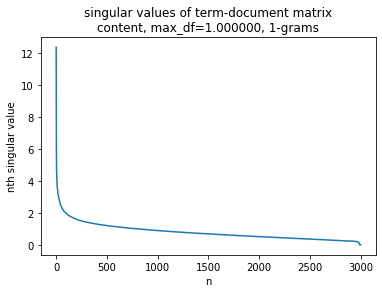

In [43]:
# 1-grams, content, max_df=1.0
# experiment with a good reduced rank to find one that explains most of the variance in the term-document matrices
X_train_tfidf[1]['content'][2]

# plot the singular values (scree plot) to find a knee that suggests underlying low rank structure
rank = 2999
svd = TruncatedSVD(rank)
svd.fit(X_train_tfidf[1]['content'][2])
print(svd.explained_variance_ratio_.sum())
fig, ax = plt.subplots()
ax.plot(svd.singular_values_)
ax.set(xlabel='n', ylabel='nth singular value', title = ('singular values of term-document matrix\ncontent, max_df=%f, %d-grams' % (max_dfs[2], 1)))

In [44]:
# 500 also seems reasonable for this given scree plot
rank = 1000
svd = TruncatedSVD(rank)
svd.fit(X_train_tfidf[1]['content'][2])
print(svd.explained_variance_ratio_.sum())

# dictionary of TruncatedSVD transforms
(lsa[1]['content']).append(make_pipeline(svd, Normalizer(copy=False)))

# dictionary of tf-idf training data after TruncatedSVD transform
(X_train_lsa[1]['content']).append(lsa[1]['content'][2].fit_transform(X_train_tfidf[1]['content'][2]))

# dictionary of tf-idf test data after TruncatedSVD transfrom (transform was learned from training data)
(X_test_lsa[1]['content']).append(lsa[1]['content'][2].transform(X_test_tfidf[1]['content'][2]))

0.7744791203640696


1.0


[Text(0, 0.5, 'nth singular value'),
 Text(0.5, 0, 'n'),
 Text(0.5, 1.0, 'singular values of term-document matrix\ncontent, max_df=1.000000, 2-grams')]

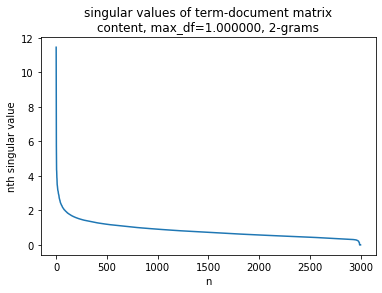

In [45]:
# 2-grams, content, max_df=1.0
# experiment with a good reduced rank to find one that explains most of the variance in the term-document matrices
X_train_tfidf[2]['content'][2]

# plot the singular values (scree plot) to find a knee that suggests underlying low rank structure
rank = 2999
svd = TruncatedSVD(rank)
svd.fit(X_train_tfidf[2]['content'][2])
print(svd.explained_variance_ratio_.sum())
fig, ax = plt.subplots()
ax.plot(svd.singular_values_)
ax.set(xlabel='n', ylabel='nth singular value', title = ('singular values of term-document matrix\ncontent, max_df=%f, %d-grams' % (max_dfs[2], 2)))

In [46]:
# 500 also seems reasonable for this given scree plot
rank = 1050
svd = TruncatedSVD(rank)
svd.fit(X_train_tfidf[2]['content'][2])
print(svd.explained_variance_ratio_.sum())

# dictionary of TruncatedSVD transforms
(lsa[2]['content']).append(make_pipeline(svd, Normalizer(copy=False)))

# dictionary of tf-idf training data after TruncatedSVD transform
(X_train_lsa[2]['content']).append(lsa[2]['content'][2].fit_transform(X_train_tfidf[2]['content'][2]))

# dictionary of tf-idf test data after TruncatedSVD transfrom (transform was learned from training data)
(X_test_lsa[2]['content']).append(lsa[2]['content'][2].transform(X_test_tfidf[2]['content'][2]))

0.752895946936116


1.0000000000000004


[Text(0, 0.5, 'nth singular value'),
 Text(0.5, 0, 'n'),
 Text(0.5, 1.0, 'singular values of term-document matrix\ncontent, max_df=1.000000, 3-grams')]

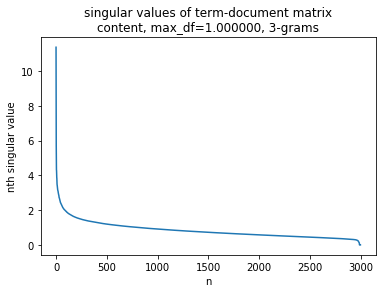

In [47]:
# 3-grams, content, max_df=1.0
# experiment with a good reduced rank to find one that explains most of the variance in the term-document matrices
X_train_tfidf[3]['content'][2]

# plot the singular values (scree plot) to find a knee that suggests underlying low rank structure
rank = 2999
svd = TruncatedSVD(rank)
svd.fit(X_train_tfidf[3]['content'][2])
print(svd.explained_variance_ratio_.sum())
fig, ax = plt.subplots()
ax.plot(svd.singular_values_)
ax.set(xlabel='n', ylabel='nth singular value', title = ('singular values of term-document matrix\ncontent, max_df=%f, %d-grams' % (max_dfs[2], 3)))

In [48]:
# 500 also seems reasonable for this given scree plot
rank = 1060
svd = TruncatedSVD(rank)
svd.fit(X_train_tfidf[3]['content'][2])
print(svd.explained_variance_ratio_.sum())

# dictionary of TruncatedSVD transforms
(lsa[3]['content']).append(make_pipeline(svd, Normalizer(copy=False)))

# dictionary of tf-idf training data after TruncatedSVD transform
(X_train_lsa[3]['content']).append(lsa[3]['content'][2].fit_transform(X_train_tfidf[3]['content'][2]))

# dictionary of tf-idf test data after TruncatedSVD transfrom (transform was learned from training data)
(X_test_lsa[3]['content']).append(lsa[3]['content'][2].transform(X_test_tfidf[3]['content'][2]))

0.7545393280918429


750
0.9999999999999994


[Text(0, 0.5, 'nth singular value'),
 Text(0.5, 0, 'n'),
 Text(0.5, 1.0, 'singular values of term-document matrix\ntitle, max_df=0.250000, 1-grams')]

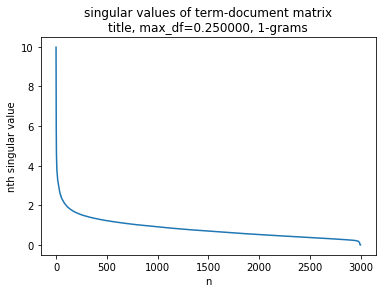

In [49]:
# now do same thing for pre-pending title of the article to content
# 1-grams, title, max_df=0.25
# experiment with a good reduced rank to find one that explains most of the variance in the term-document matrices
X_train_tfidf[1]['title'][0]
print(len(X_test['title']))

# plot the singular values (scree plot) to find a knee that suggests underlying low rank structure
rank = 2999
svd = TruncatedSVD(rank)
svd.fit(X_train_tfidf[1]['title'][0])
print(svd.explained_variance_ratio_.sum())
fig, ax = plt.subplots()
ax.plot(svd.singular_values_)
ax.set(xlabel='n', ylabel='nth singular value', title = ('singular values of term-document matrix\ntitle, max_df=%f, %d-grams' % (max_dfs[0], 1)))

In [51]:
# 500 seems reasonable
rank = 1000
svd = TruncatedSVD(rank)
svd.fit(X_train_tfidf[1]['title'][0])
print(svd.explained_variance_ratio_.sum())

# dictionary of TruncatedSVD transforms
lsa[1]['title'] = []
(lsa[1]['title']).append(make_pipeline(svd, Normalizer(copy=False)))

# dictionary of tf-idf training data after TruncatedSVD transform
X_train_lsa[1]['title'] = []
(X_train_lsa[1]['title']).append(lsa[1]['title'][0].fit_transform(X_train_tfidf[1]['title'][0]))

# dictionary of tf-idf test data after TruncatedSVD transfrom (transform was learned from training data)
#X_test_lsa = {}
X_test_lsa[1]['title'] = []
(X_test_lsa[1]['title']).append(lsa[1]['title'][0].transform(X_test_tfidf[1]['title'][0]))

0.7731862204172733


750
1.0000000000000004


[Text(0, 0.5, 'nth singular value'),
 Text(0.5, 0, 'n'),
 Text(0.5, 1.0, 'singular values of term-document matrix\ntitle, max_df=0.250000, 2-grams')]

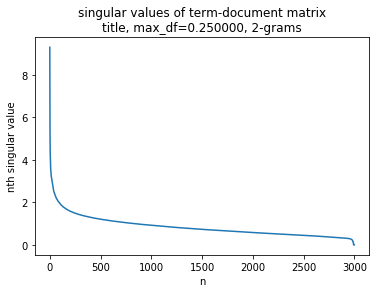

In [52]:
# 2-grams, title, max_df=0.25
# experiment with a good reduced rank to find one that explains most of the variance in the term-document matrices
X_train_tfidf[2]['title'][0]
print(len(X_test['title']))

# plot the singular values (scree plot) to find a knee that suggests underlying low rank structure
rank = 2999
svd = TruncatedSVD(rank)
svd.fit(X_train_tfidf[2]['title'][0])
print(svd.explained_variance_ratio_.sum())
fig, ax = plt.subplots()
ax.plot(svd.singular_values_)
ax.set(xlabel='n', ylabel='nth singular value', title = ('singular values of term-document matrix\ntitle, max_df=%f, %d-grams' % (max_dfs[0], 2)))

In [53]:
# 500 seems reasonable
rank = 1050
svd = TruncatedSVD(rank)
svd.fit(X_train_tfidf[2]['title'][0])
print(svd.explained_variance_ratio_.sum())

# dictionary of TruncatedSVD transforms
lsa[2]['title'] = []
(lsa[2]['title']).append(make_pipeline(svd, Normalizer(copy=False)))

# dictionary of tf-idf training data after TruncatedSVD transform
X_train_lsa[2]['title'] = []
(X_train_lsa[2]['title']).append(lsa[2]['title'][0].fit_transform(X_train_tfidf[2]['title'][0]))

# dictionary of tf-idf test data after TruncatedSVD transfrom (transform was learned from training data)
#X_test_lsa = {}
X_test_lsa[2]['title'] = []
(X_test_lsa[2]['title']).append(lsa[2]['title'][0].transform(X_test_tfidf[2]['title'][0]))

0.7510763625798396


750
0.9999999999999996


[Text(0, 0.5, 'nth singular value'),
 Text(0.5, 0, 'n'),
 Text(0.5, 1.0, 'singular values of term-document matrix\ntitle, max_df=0.250000, 3-grams')]

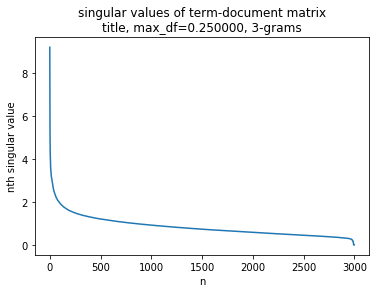

In [54]:
# 3-grams, title, max_df=0.25
# experiment with a good reduced rank to find one that explains most of the variance in the term-document matrices
X_train_tfidf[3]['title'][0]
print(len(X_test['title']))

# plot the singular values (scree plot) to find a knee that suggests underlying low rank structure
rank = 2999
svd = TruncatedSVD(rank)
svd.fit(X_train_tfidf[3]['title'][0])
print(svd.explained_variance_ratio_.sum())
fig, ax = plt.subplots()
ax.plot(svd.singular_values_)
ax.set(xlabel='n', ylabel='nth singular value', title = ('singular values of term-document matrix\ntitle, max_df=%f, %d-grams' % (max_dfs[0], 3)))

In [55]:
# 500 seems reasonable
rank = 1060
svd = TruncatedSVD(rank)
svd.fit(X_train_tfidf[3]['title'][0])
print(svd.explained_variance_ratio_.sum())

# dictionary of TruncatedSVD transforms
lsa[3]['title'] = []
(lsa[3]['title']).append(make_pipeline(svd, Normalizer(copy=False)))

# dictionary of tf-idf training data after TruncatedSVD transform
X_train_lsa[3]['title'] = []
(X_train_lsa[3]['title']).append(lsa[3]['title'][0].fit_transform(X_train_tfidf[3]['title'][0]))

# dictionary of tf-idf test data after TruncatedSVD transfrom (transform was learned from training data)
#X_test_lsa = {}
X_test_lsa[3]['title'] = []
(X_test_lsa[3]['title']).append(lsa[3]['title'][0].transform(X_test_tfidf[3]['title'][0]))

0.7527818937502078


750
1.0000000000000002


[Text(0, 0.5, 'nth singular value'),
 Text(0.5, 0, 'n'),
 Text(0.5, 1.0, 'singular values of term-document matrix\ntitle, max_df=0.500000, 1-grams')]

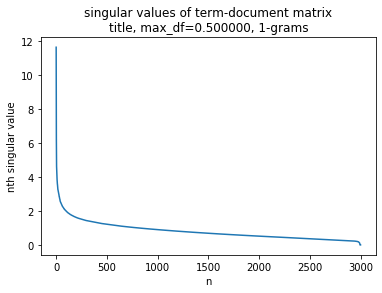

In [56]:
# 1-grams, title, max_df=0.5
# experiment with a good reduced rank to find one that explains most of the variance in the term-document matrices
X_train_tfidf[1]['title'][1]
print(len(X_test['title']))

# plot the singular values (scree plot) to find a knee that suggests underlying low rank structure
rank = 2999
svd = TruncatedSVD(rank)
svd.fit(X_train_tfidf[1]['title'][1])
print(svd.explained_variance_ratio_.sum())
fig, ax = plt.subplots()
ax.plot(svd.singular_values_)
ax.set(xlabel='n', ylabel='nth singular value', title = ('singular values of term-document matrix\ntitle, max_df=%f, %d-grams' % (max_dfs[1], 1)))

In [57]:
# 500 seems reasonable
rank = 1000
svd = TruncatedSVD(rank)
svd.fit(X_train_tfidf[1]['title'][1])
print(svd.explained_variance_ratio_.sum())

# dictionary of TruncatedSVD transforms
(lsa[1]['title']).append(make_pipeline(svd, Normalizer(copy=False)))

# dictionary of tf-idf training data after TruncatedSVD transform
(X_train_lsa[1]['title']).append(lsa[1]['title'][1].fit_transform(X_train_tfidf[1]['title'][1]))

# dictionary of tf-idf test data after TruncatedSVD transfrom (transform was learned from training data)
(X_test_lsa[1]['title']).append(lsa[1]['title'][1].transform(X_test_tfidf[1]['title'][1]))

0.7771804232626066


750
1.0000000000000002


[Text(0, 0.5, 'nth singular value'),
 Text(0.5, 0, 'n'),
 Text(0.5, 1.0, 'singular values of term-document matrix\ntitle, max_df=0.500000, 2-grams')]

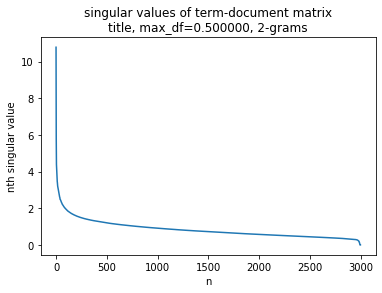

In [58]:
# 2-grams, title, max_df=0.5
# experiment with a good reduced rank to find one that explains most of the variance in the term-document matrices
X_train_tfidf[2]['title'][1]
print(len(X_test['title']))

# plot the singular values (scree plot) to find a knee that suggests underlying low rank structure
rank = 2999
svd = TruncatedSVD(rank)
svd.fit(X_train_tfidf[2]['title'][1])
print(svd.explained_variance_ratio_.sum())
fig, ax = plt.subplots()
ax.plot(svd.singular_values_)
ax.set(xlabel='n', ylabel='nth singular value', title = ('singular values of term-document matrix\ntitle, max_df=%f, %d-grams' % (max_dfs[1], 2)))

In [59]:
# 500 seems reasonable
rank = 1050
svd = TruncatedSVD(rank)
svd.fit(X_train_tfidf[2]['title'][1])
print(svd.explained_variance_ratio_.sum())

# dictionary of TruncatedSVD transforms
(lsa[2]['title']).append(make_pipeline(svd, Normalizer(copy=False)))

# dictionary of tf-idf training data after TruncatedSVD transform
(X_train_lsa[2]['title']).append(lsa[2]['title'][1].fit_transform(X_train_tfidf[2]['title'][1]))

# dictionary of tf-idf test data after TruncatedSVD transfrom (transform was learned from training data)
(X_test_lsa[2]['title']).append(lsa[2]['title'][1].transform(X_test_tfidf[2]['title'][1]))

0.7559692403750742


750
1.0000000000000002


[Text(0, 0.5, 'nth singular value'),
 Text(0.5, 0, 'n'),
 Text(0.5, 1.0, 'singular values of term-document matrix\ntitle, max_df=0.500000, 3-grams')]

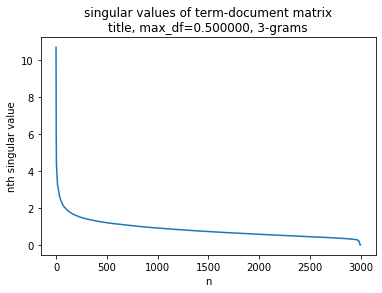

In [60]:
# 3-grams, title, max_df=0.5
# experiment with a good reduced rank to find one that explains most of the variance in the term-document matrices
X_train_tfidf[3]['title'][1]
print(len(X_test['title']))

# plot the singular values (scree plot) to find a knee that suggests underlying low rank structure
rank = 2999
svd = TruncatedSVD(rank)
svd.fit(X_train_tfidf[3]['title'][1])
print(svd.explained_variance_ratio_.sum())
fig, ax = plt.subplots()
ax.plot(svd.singular_values_)
ax.set(xlabel='n', ylabel='nth singular value', title = ('singular values of term-document matrix\ntitle, max_df=%f, %d-grams' % (max_dfs[1], 3)))

In [61]:
# 500 seems reasonable
rank = 1060
svd = TruncatedSVD(rank)
svd.fit(X_train_tfidf[3]['title'][1])
print(svd.explained_variance_ratio_.sum())

# dictionary of TruncatedSVD transforms
(lsa[3]['title']).append(make_pipeline(svd, Normalizer(copy=False)))

# dictionary of tf-idf training data after TruncatedSVD transform
(X_train_lsa[3]['title']).append(lsa[3]['title'][1].fit_transform(X_train_tfidf[3]['title'][1]))

# dictionary of tf-idf test data after TruncatedSVD transfrom (transform was learned from training data)
(X_test_lsa[3]['title']).append(lsa[3]['title'][1].transform(X_test_tfidf[3]['title'][1]))

0.7575354961818466


1.0000000000000002


[Text(0, 0.5, 'nth singular value'),
 Text(0.5, 0, 'n'),
 Text(0.5, 1.0, 'singular values of term-document matrix\ntitle, max_df=1.000000, 1-grams')]

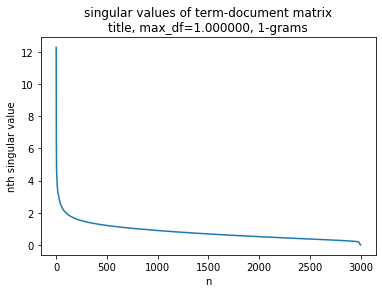

In [62]:
# 1-grams, title, max_df=1.0
# experiment with a good reduced rank to find one that explains most of the variance in the term-document matrices
X_train_tfidf[1]['title'][2]
#print(len(X_test['title']))

# plot the singular values (scree plot) to find a knee that suggests underlying low rank structure
rank = 2999
svd = TruncatedSVD(rank)
svd.fit(X_train_tfidf[1]['title'][2])
print(svd.explained_variance_ratio_.sum())
fig, ax = plt.subplots()
ax.plot(svd.singular_values_)
ax.set(xlabel='n', ylabel='nth singular value', title = ('singular values of term-document matrix\ntitle, max_df=%f, %d-grams' % (max_dfs[2], 1)))

In [63]:
# 500 seems reasonable
rank = 1000
svd = TruncatedSVD(rank)
svd.fit(X_train_tfidf[1]['title'][2])
print(svd.explained_variance_ratio_.sum())

# dictionary of TruncatedSVD transforms
(lsa[1]['title']).append(make_pipeline(svd, Normalizer(copy=False)))

# dictionary of tf-idf training data after TruncatedSVD transform
(X_train_lsa[1]['title']).append(lsa[1]['title'][2].fit_transform(X_train_tfidf[1]['title'][2]))

# dictionary of tf-idf test data after TruncatedSVD transfrom (transform was learned from training data)
(X_test_lsa[1]['title']).append(lsa[1]['title'][2].transform(X_test_tfidf[1]['title'][2]))

0.7779658954830418


1.0000000000000002


[Text(0, 0.5, 'nth singular value'),
 Text(0.5, 0, 'n'),
 Text(0.5, 1.0, 'singular values of term-document matrix\ntitle, max_df=1.000000, 2-grams')]

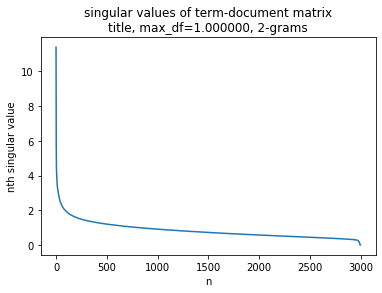

In [64]:
# 2-grams, title, max_df=1.0
# experiment with a good reduced rank to find one that explains most of the variance in the term-document matrices
X_train_tfidf[2]['title'][2]
#print(len(X_test['title']))

# plot the singular values (scree plot) to find a knee that suggests underlying low rank structure
rank = 2999
svd = TruncatedSVD(rank)
svd.fit(X_train_tfidf[2]['title'][2])
print(svd.explained_variance_ratio_.sum())
fig, ax = plt.subplots()
ax.plot(svd.singular_values_)
ax.set(xlabel='n', ylabel='nth singular value', title = ('singular values of term-document matrix\ntitle, max_df=%f, %d-grams' % (max_dfs[2], 2)))

In [65]:
# 500 seems reasonable
rank = 1050
svd = TruncatedSVD(rank)
svd.fit(X_train_tfidf[2]['title'][2])
print(svd.explained_variance_ratio_.sum())

# dictionary of TruncatedSVD transforms
(lsa[2]['title']).append(make_pipeline(svd, Normalizer(copy=False)))

# dictionary of tf-idf training data after TruncatedSVD transform
(X_train_lsa[2]['title']).append(lsa[2]['title'][2].fit_transform(X_train_tfidf[2]['title'][2]))

# dictionary of tf-idf test data after TruncatedSVD transfrom (transform was learned from training data)
(X_test_lsa[2]['title']).append(lsa[2]['title'][2].transform(X_test_tfidf[2]['title'][2]))

0.7568542592277008


1.0000000000000002


[Text(0, 0.5, 'nth singular value'),
 Text(0.5, 0, 'n'),
 Text(0.5, 1.0, 'singular values of term-document matrix\ntitle, max_df=1.000000, 3-grams')]

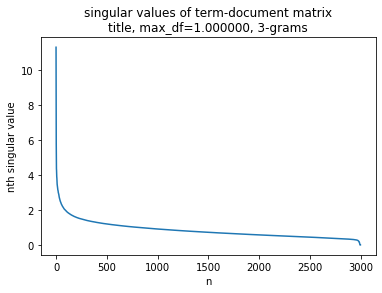

In [66]:
# 3-grams, title, max_df=1.0
# experiment with a good reduced rank to find one that explains most of the variance in the term-document matrices
X_train_tfidf[3]['title'][2]
#print(len(X_test['title']))

# plot the singular values (scree plot) to find a knee that suggests underlying low rank structure
rank = 2999
svd = TruncatedSVD(rank)
svd.fit(X_train_tfidf[3]['title'][2])
print(svd.explained_variance_ratio_.sum())
fig, ax = plt.subplots()
ax.plot(svd.singular_values_)
ax.set(xlabel='n', ylabel='nth singular value', title = ('singular values of term-document matrix\ntitle, max_df=%f, %d-grams' % (max_dfs[2], 3)))

In [67]:
# 500 seems reasonable
rank = 1060
svd = TruncatedSVD(rank)
svd.fit(X_train_tfidf[3]['title'][2])
print(svd.explained_variance_ratio_.sum())

# dictionary of TruncatedSVD transforms
(lsa[3]['title']).append(make_pipeline(svd, Normalizer(copy=False)))

# dictionary of tf-idf training data after TruncatedSVD transform
(X_train_lsa[3]['title']).append(lsa[3]['title'][2].fit_transform(X_train_tfidf[3]['title'][2]))

# dictionary of tf-idf test data after TruncatedSVD transfrom (transform was learned from training data)
(X_test_lsa[3]['title']).append(lsa[3]['title'][2].transform(X_test_tfidf[3]['title'][2]))

0.7583555598310412


In [68]:
# sanity check lengths
print(len(X_train))
print(len(X_train['content']))
print(len(X_train['title']))
print(len(X_test))
print(len(X_test['content']))
print(len(X_test['title']))

print(len(X_train_tfidf))
for n in max_ngram:
    print(len(X_train_tfidf[n]['content']))
    print(X_train_tfidf[n]['content'][0].shape)
    print(X_train_tfidf[n]['content'][1].shape)
    print(X_train_tfidf[n]['content'][2].shape)
    print(len(X_train_tfidf[n]['title']))
    print(X_train_tfidf[n]['title'][0].shape)
    print(X_train_tfidf[n]['title'][1].shape)
    print(X_train_tfidf[n]['title'][2].shape)

print(len(X_test_tfidf))
for n in max_ngram:
    print(len(X_test_tfidf[n]['content']))
    print(X_test_tfidf[n]['content'][0].shape)
    print(X_test_tfidf[n]['content'][1].shape)
    print(X_test_tfidf[n]['content'][2].shape)
    print(len(X_test_tfidf[n]['title']))
    print(X_test_tfidf[n]['title'][0].shape)
    print(X_test_tfidf[n]['title'][1].shape)
    print(X_test_tfidf[n]['title'][2].shape)

print(len(lsa))
for n in max_ngram:
    print(len(lsa[n]['content']))
    print(len(lsa[n]['title']))

print(len(X_train_lsa))
for n in max_ngram:
    print(len(X_train_lsa[n]['content']))
    print(X_train_lsa[n]['content'][0].shape)
    print(X_train_lsa[n]['content'][1].shape)
    print(X_train_lsa[n]['content'][2].shape)
    print(len(X_train_lsa[n]['title']))
    print(X_train_lsa[n]['title'][0].shape)
    print(X_train_lsa[n]['title'][1].shape)
    print(X_train_lsa[n]['title'][2].shape)

print(len(X_test_lsa))
for n in max_ngram:
    print(len(X_test_lsa[n]['content']))
    print(X_test_lsa[n]['content'][0].shape)
    print(X_test_lsa[n]['content'][1].shape)
    print(X_test_lsa[n]['content'][2].shape)
    print(len(X_test_lsa[n]['title']))
    print(X_test_lsa[n]['title'][0].shape)
    print(X_test_lsa[n]['title'][1].shape)
    print(X_test_lsa[n]['title'][2].shape)

print(len(y_train))
print(len(y_train['content']))
print(len(y_train['title']))

print(len(y_test))
print(len(y_test['content']))
print(len(y_test['title']))

2
3000
3000
2
750
750
3
3
(3000, 8309)
(3000, 8381)
(3000, 8391)
3
(3000, 8345)
(3000, 8418)
(3000, 8428)
3
(3000, 13959)
(3000, 14032)
(3000, 14042)
3
(3000, 14089)
(3000, 14163)
(3000, 14173)
3
(3000, 14861)
(3000, 14934)
(3000, 14944)
3
(3000, 15003)
(3000, 15077)
(3000, 15087)
3
3
(750, 8309)
(750, 8381)
(750, 8391)
3
(750, 8345)
(750, 8418)
(750, 8428)
3
(750, 13959)
(750, 14032)
(750, 14042)
3
(750, 14089)
(750, 14163)
(750, 14173)
3
(750, 14861)
(750, 14934)
(750, 14944)
3
(750, 15003)
(750, 15077)
(750, 15087)
3
3
3
3
3
3
3
3
3
(3000, 1000)
(3000, 1000)
(3000, 1000)
3
(3000, 1000)
(3000, 1000)
(3000, 1000)
3
(3000, 1050)
(3000, 1050)
(3000, 1050)
3
(3000, 1050)
(3000, 1050)
(3000, 1050)
3
(3000, 1060)
(3000, 1060)
(3000, 1060)
3
(3000, 1060)
(3000, 1060)
(3000, 1060)
3
3
(750, 1000)
(750, 1000)
(750, 1000)
3
(750, 1000)
(750, 1000)
(750, 1000)
3
(750, 1050)
(750, 1050)
(750, 1050)
3
(750, 1050)
(750, 1050)
(750, 1050)
3
(750, 1060)
(750, 1060)
(750, 1060)
3
(750, 1060)
(750, 10

In [189]:
from sklearn.model_selection import GridSearchCV, cross_val_score

algorithm_comparison = pd.DataFrame(columns=['algorithm', 'n_train', 'n_test', 'use_title', 'max_df', 'n-gram', 'cv_score', 'train_acc', 'test_acc'])
cv_results = {'title': [None]*3, 'content': [None]*3}

def algorithm_score(classifier, params, use_title, vectorizer_idx, i):
    # use_title: True or False - if pre-pending title to article content
    # vectorizer_idx: (n_gram, idx)
    #      n_gram - 1, 2, 3 - max words used in n-grams
    #      idx - 0, 1, 2 - idx corresponding to max document frequency (0 has max_df=0.25, 1 has max_df=0.5, 2 has max_df=1.)
    key = 'title' if use_title else 'content'
    n = vectorizer_idx[0]
    df = vectorizer_idx[1]
    
    algorithm_comparison.loc[i, 'use_title'] = key
    algorithm_comparison.loc[i, 'max_df'] = max_dfs[df]
    algorithm_comparison.loc[i, 'n-gram'] = n
    
    print('use_title: ', key, ', max_df: ', max_dfs[df], 'n-gram: ', n)
    
    # 5-fold cross-validation
    grid_search = GridSearchCV(classifier, params, cv=5, verbose=2)
    grid_search.fit(np.array(X_train_lsa[key][vectorizer_idx]), np.array(y_train[key]))
    cv_results[key][vectorizer_idx] = grid_search.cv_results_
    
    # compute accuracies with best result from cross-validation
    best = grid_search.best_estimator_
    print('Best parameters: ', grid_search.best_params_)
    
    # show best scores for cross-validation
    cv_score = cross_val_score(best, X=np.array(X_train_lsa[key][vectorizer_idx]), y = np.array(y_train[key]), cv=5)
    print('CV score for each fold (best estimator): ', cv_score)
    print('CV score averaged across folds (best estimator): ', cv_score.mean())
    algorithm_comparison.loc[i, 'cv_score'] = cv_score.mean()
    
    
    # use best parameters on whole training set for train accuracy
    best_all = best.fit(np.array(X_train_lsa[key][vectorizer_idx]), np.array(y_train[key]))
    train_acc = best_all.score(X=np.array(X_train_lsa[key][vectorizer_idx]), y=np.array(y_train[key]))
    print('Training accuracy (best estimator): ', train_acc)
    algorithm_comparison.loc[i, 'train_acc'] = train_acc
    
    # use best parameters on whole training set for test accuracy
    test_acc = best_all.score(X=np.array(X_test_lsa[key][vectorizer_idx]), y=np.array(y_test[key]))
    print('Test accuracy (best estimator): ', test_acc)
    algorithm_comparison.loc[i, 'test_acc'] = test_acc
    
    algorithm_comparison.loc[i, 'n_train'] = len(y_train[key])
    algorithm_comparison.loc[i, 'n_test'] = len(y_test[key])
       

In [169]:
from sklearn.ensemble import RandomForestClassifier

params = {'criterion': ['entropy', 'gini'],
         'n_estimators': [10, 50, 100]}
classifier = RandomForestClassifier(max_features=None, n_jobs=-1)

i = 0
print('----Random Forest-----')
algorithm_comparison.loc[i, 'algorithm'] = 'RandomForest'
# chose one with highest variance explained by SVD
algorithm_score(classifier, params, True, 2, i)
i += 1

----Random Forest-----
use_title:  title , max_df:  1.0
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] criterion=entropy, n_estimators=10 ..............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............... criterion=entropy, n_estimators=10, total=  22.5s
[CV] criterion=entropy, n_estimators=10 ..............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   22.5s remaining:    0.0s


[CV] ............... criterion=entropy, n_estimators=10, total=  19.9s
[CV] criterion=entropy, n_estimators=10 ..............................
[CV] ............... criterion=entropy, n_estimators=10, total=  20.0s
[CV] criterion=entropy, n_estimators=10 ..............................
[CV] ............... criterion=entropy, n_estimators=10, total=  20.1s
[CV] criterion=entropy, n_estimators=10 ..............................
[CV] ............... criterion=entropy, n_estimators=10, total=  20.9s
[CV] criterion=entropy, n_estimators=50 ..............................
[CV] ............... criterion=entropy, n_estimators=50, total= 1.8min
[CV] criterion=entropy, n_estimators=50 ..............................
[CV] ............... criterion=entropy, n_estimators=50, total= 1.6min
[CV] criterion=entropy, n_estimators=50 ..............................
[CV] ............... criterion=entropy, n_estimators=50, total= 1.7min
[CV] criterion=entropy, n_estimators=50 ..............................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 43.2min finished


Best parameters:  {'criterion': 'entropy', 'n_estimators': 100}
CV score for each fold (best estimator):  [0.32666667 0.34166667 0.33333333 0.33       0.31      ]
CV score averaged across folds (best estimator):  0.32833333333333337
Training accuracy (best estimator):  1.0
Test accuracy (best estimator):  0.31466666666666665


In [170]:
algorithm_comparison.head()

,algorithm,n_train,n_test,use_title,max_df,cv_score,train_acc,test_acc
0,RandomForest,3000,750,title,1,0.328333,1,0.314667


In [171]:
params = {'criterion': ['entropy', 'gini']}
classifier = RandomForestClassifier(max_features=None, n_jobs=-1, n_estimators=200)
print('----Random Forest-----')
algorithm_comparison.loc[i, 'algorithm'] = 'RandomForest'
# chose one with highest variance explained by SVD
algorithm_score(classifier, params, True, 2, i)
i += 1

----Random Forest-----
use_title:  title , max_df:  1.0
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] criterion=entropy ...............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................ criterion=entropy, total= 6.8min
[CV] criterion=entropy ...............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.8min remaining:    0.0s


[CV] ................................ criterion=entropy, total= 7.4min
[CV] criterion=entropy ...............................................
[CV] ................................ criterion=entropy, total= 7.4min
[CV] criterion=entropy ...............................................
[CV] ................................ criterion=entropy, total= 6.9min
[CV] criterion=entropy ...............................................
[CV] ................................ criterion=entropy, total= 7.4min
[CV] criterion=gini ..................................................
[CV] ................................... criterion=gini, total= 3.1min
[CV] criterion=gini ..................................................
[CV] ................................... criterion=gini, total= 3.0min
[CV] criterion=gini ..................................................
[CV] ................................... criterion=gini, total= 2.8min
[CV] criterion=gini ..................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 51.1min finished


Best parameters:  {'criterion': 'gini'}
CV score for each fold (best estimator):  [0.32666667 0.35666667 0.35       0.33666667 0.32166667]
CV score averaged across folds (best estimator):  0.33833333333333326
Training accuracy (best estimator):  1.0
Test accuracy (best estimator):  0.332


In [173]:
print(cv_results)
algorithm_comparison.head()

{'title': [None, None, {'mean_fit_time': array([430.53904176, 182.19043317]), 'std_fit_time': array([14.92752001,  8.22952975]), 'mean_score_time': array([0.1545742 , 0.12165484]), 'std_score_time': array([0.06154177, 0.01326442]), 'param_criterion': masked_array(data=['entropy', 'gini'],
             mask=[False, False],
       fill_value='?',
            dtype=object), 'params': [{'criterion': 'entropy'}, {'criterion': 'gini'}], 'split0_test_score': array([0.33      , 0.33666667]), 'split1_test_score': array([0.34166667, 0.34833333]), 'split2_test_score': array([0.34, 0.36]), 'split3_test_score': array([0.34333333, 0.35166667]), 'split4_test_score': array([0.32166667, 0.35166667]), 'mean_test_score': array([0.33533333, 0.34966667]), 'std_test_score': array([0.00825967, 0.00755719]), 'rank_test_score': array([2, 1], dtype=int32)}], 'content': [None, None, None]}


,algorithm,n_train,n_test,use_title,max_df,cv_score,train_acc,test_acc
0,RandomForest,3000,750,title,1,0.328333,1,0.314667
1,RandomForest,3000,750,title,1,0.338333,1,0.332


In [174]:
# try other parameters - use sqrt(n) vs n samples with replacement per tree (max_features)
#                      - use min samples to split decision tree (2 vs .05*n_train)
params = {'criterion': ['entropy', 'gini'], 'min_samples_split': [2, .05], 'max_features': ['auto', None]}
classifier = RandomForestClassifier(max_features=None, n_jobs=-1, n_estimators=200)
print('----Random Forest-----')
algorithm_comparison.loc[i, 'algorithm'] = 'RandomForest'
# chose one with highest variance explained by SVD
algorithm_score(classifier, params, True, 2, i)
i += 1

----Random Forest-----
use_title:  title , max_df:  1.0
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] criterion=entropy, max_features=auto, min_samples_split=2 .......


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  criterion=entropy, max_features=auto, min_samples_split=2, total=  19.6s
[CV] criterion=entropy, max_features=auto, min_samples_split=2 .......


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.6s remaining:    0.0s


[CV]  criterion=entropy, max_features=auto, min_samples_split=2, total=  14.0s
[CV] criterion=entropy, max_features=auto, min_samples_split=2 .......
[CV]  criterion=entropy, max_features=auto, min_samples_split=2, total=  15.0s
[CV] criterion=entropy, max_features=auto, min_samples_split=2 .......
[CV]  criterion=entropy, max_features=auto, min_samples_split=2, total=  13.8s
[CV] criterion=entropy, max_features=auto, min_samples_split=2 .......
[CV]  criterion=entropy, max_features=auto, min_samples_split=2, total=  13.8s
[CV] criterion=entropy, max_features=auto, min_samples_split=0.05 ....
[CV]  criterion=entropy, max_features=auto, min_samples_split=0.05, total=   9.5s
[CV] criterion=entropy, max_features=auto, min_samples_split=0.05 ....
[CV]  criterion=entropy, max_features=auto, min_samples_split=0.05, total=   9.3s
[CV] criterion=entropy, max_features=auto, min_samples_split=0.05 ....
[CV]  criterion=entropy, max_features=auto, min_samples_split=0.05, total=   9.5s
[CV] criteri

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed: 82.4min finished


Best parameters:  {'criterion': 'entropy', 'max_features': 'auto', 'min_samples_split': 0.05}
CV score for each fold (best estimator):  [0.33666667 0.39333333 0.35       0.37166667 0.31666667]
CV score averaged across folds (best estimator):  0.3536666666666667
Training accuracy (best estimator):  0.6816666666666666
Test accuracy (best estimator):  0.35333333333333333


In [179]:
cv_results_table = pd.DataFrame(cv_results['title'][2])
cv_results_table.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_features,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,15.144393,2.229123,0.128075,0.039729,entropy,auto,2,"{'criterion': 'entropy', 'max_features': 'auto...",0.300000,0.311667,0.330000,0.313333,0.285000,0.308000,0.014959,5
1,9.439076,0.244533,0.107290,0.000868,entropy,auto,0.05,"{'criterion': 'entropy', 'max_features': 'auto...",0.325000,0.360000,0.366667,0.361667,0.341667,0.351000,0.015513,1
2,399.881713,10.917164,0.106763,0.001722,entropy,None,2,"{'criterion': 'entropy', 'max_features': None,...",0.340000,0.348333,0.353333,0.336667,0.320000,0.339667,0.011470,3
3,290.076585,8.883343,0.109759,0.004441,entropy,None,0.05,"{'criterion': 'entropy', 'max_features': None,...",0.283333,0.285000,0.286667,0.290000,0.290000,0.287000,0.002667,8
4,6.207917,0.278743,0.107767,0.001345,gini,auto,2,"{'criterion': 'gini', 'max_features': 'auto', ...",0.266667,0.353333,0.301667,0.325000,0.288333,0.307000,0.029915,6
5,4.030873,0.323433,0.106199,0.001360,gini,auto,0.05,"{'criterion': 'gini', 'max_features': 'auto', ...",0.336667,0.371667,0.358333,0.356667,0.306667,0.346000,0.022623,2
6,160.327225,6.653711,0.127912,0.041317,gini,None,2,"{'criterion': 'gini', 'max_features': None, 'm...",0.326667,0.363333,0.338333,0.343333,0.325000,0.339333,0.013848,4
7,103.196231,3.202736,0.107017,0.001380,gini,None,0.05,"{'criterion': 'gini', 'max_features': None, 'm...",0.295000,0.315000,0.298333,0.320000,0.280000,0.301667,0.014414,7


In [188]:
#print(y_train['title'])
#print(np.max(y_train['title']))
#print(np.array(y_train['title']) == 1)
class_frequencies = [np.sum(np.array(y_train['title']) == i) for i in range(np.max(y_train['title']))]
print('class frequencies: ', class_frequencies)
class_frequencies_test = [np.sum(np.array(y_test['title']) == i) for i in range(np.max(y_test['title']))]
print(class_frequencies_test)

class frequencies:  [200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200]
[50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]


In [194]:
from sklearn.svm import SVC

params = [{'kernel' : ['linear'], 'C': [1e-1, 1, 10]}, 
          {'kernel' : ['rbf'], 'C': [1e-1, 1, 10], 'gamma' : [1e-4, 1e-3, 1e-2, 1e-1]}]
classifier = SVC()
print('----Support Vector Machine-----')
algorithm_comparison.loc[i, 'algorithm'] = 'SVM'
# chose one with highest variance explained by SVD
algorithm_score(classifier, params, True, 2, i)
i += 1

----Support Vector Machine-----
use_title:  title , max_df:  1.0
Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] C=0.1, kernel=linear ............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............................. C=0.1, kernel=linear, total=  12.8s
[CV] C=0.1, kernel=linear ............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.8s remaining:    0.0s


[CV] ............................. C=0.1, kernel=linear, total=  12.3s
[CV] C=0.1, kernel=linear ............................................
[CV] ............................. C=0.1, kernel=linear, total=  12.7s
[CV] C=0.1, kernel=linear ............................................
[CV] ............................. C=0.1, kernel=linear, total=  13.6s
[CV] C=0.1, kernel=linear ............................................
[CV] ............................. C=0.1, kernel=linear, total=  12.7s
[CV] C=1, kernel=linear ..............................................
[CV] ............................... C=1, kernel=linear, total=  11.0s
[CV] C=1, kernel=linear ..............................................
[CV] ............................... C=1, kernel=linear, total=  11.7s
[CV] C=1, kernel=linear ..............................................
[CV] ............................... C=1, kernel=linear, total=  11.6s
[CV] C=1, kernel=linear ..............................................
[CV] .

[CV] ................... C=10, gamma=0.0001, kernel=rbf, total=  12.6s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] .................... C=10, gamma=0.001, kernel=rbf, total=  12.6s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] .................... C=10, gamma=0.001, kernel=rbf, total=  12.5s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] .................... C=10, gamma=0.001, kernel=rbf, total=  13.2s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] .................... C=10, gamma=0.001, kernel=rbf, total=  12.6s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] .................... C=10, gamma=0.001, kernel=rbf, total=  12.9s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ..................... C=10, gamma=0.01, kernel=rbf, total=  12.9s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] .

[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed: 15.7min finished


Best parameters:  {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
CV score for each fold (best estimator):  [0.45666667 0.47833333 0.47       0.47833333 0.45833333]
CV score averaged across folds (best estimator):  0.4683333333333334
Training accuracy (best estimator):  0.939
Test accuracy (best estimator):  0.476


In [196]:
cv_results_table = pd.DataFrame(cv_results['title'][2])
cv_results_table.head(15)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,11.288270,0.425803,1.565004,0.063423,0.1,linear,NaN,"{'C': 0.1, 'kernel': 'linear'}",0.300000,0.380000,0.336667,0.355000,0.301667,0.334667,0.030865,6
1,9.637299,0.346554,1.521149,0.103748,1,linear,NaN,"{'C': 1, 'kernel': 'linear'}",0.465000,0.486667,0.455000,0.456667,0.455000,0.463667,0.012083,3
2,9.871507,0.055789,1.421024,0.011095,10,linear,NaN,"{'C': 10, 'kernel': 'linear'}",0.460000,0.461667,0.476667,0.470000,0.455000,0.464667,0.007703,2
3,11.117057,0.133438,1.537499,0.019955,0.1,rbf,0.0001,"{'C': 0.1, 'gamma': 0.0001, 'kernel': 'rbf'}",0.293333,0.376667,0.333333,0.348333,0.298333,0.330000,0.031216,7
4,11.019986,0.022035,1.542720,0.014724,0.1,rbf,0.001,"{'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}",0.291667,0.376667,0.333333,0.348333,0.298333,0.329667,0.031612,10
5,11.081633,0.098908,1.557742,0.013940,0.1,rbf,0.01,"{'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}",0.288333,0.376667,0.333333,0.348333,0.300000,0.329333,0.032121,13
6,11.138348,0.126560,1.565715,0.035525,0.1,rbf,0.1,"{'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}",0.288333,0.370000,0.330000,0.343333,0.301667,0.326667,0.029193,15
7,11.099866,0.116916,1.537987,0.018472,1,rbf,0.0001,"{'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}",0.293333,0.376667,0.333333,0.348333,0.298333,0.330000,0.031216,7
8,11.034302,0.028989,1.542059,0.016244,1,rbf,0.001,"{'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}",0.291667,0.376667,0.333333,0.348333,0.298333,0.329667,0.031612,10
9,11.111710,0.127909,1.563029,0.011170,1,rbf,0.01,"{'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}",0.288333,0.376667,0.333333,0.348333,0.300000,0.329333,0.032121,13


In [197]:
params = [{'kernel' : ['linear'], 'C': [1, 2, 5, 10]}, 
          {'kernel' : ['rbf'], 'C': [5, 10, 20], 'gamma' : [5e-2, 1e-1, 1]}]
classifier = SVC()
print('----Support Vector Machine-----')
algorithm_comparison.loc[i, 'algorithm'] = 'SVM'
# chose one with highest variance explained by SVD
algorithm_score(classifier, params, True, 2, i)
i += 1

----Support Vector Machine-----
use_title:  title , max_df:  1.0
Fitting 5 folds for each of 13 candidates, totalling 65 fits
[CV] C=1, kernel=linear ..............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............................... C=1, kernel=linear, total=  10.9s
[CV] C=1, kernel=linear ..............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.9s remaining:    0.0s


[CV] ............................... C=1, kernel=linear, total=  12.2s
[CV] C=1, kernel=linear ..............................................
[CV] ............................... C=1, kernel=linear, total=  17.0s
[CV] C=1, kernel=linear ..............................................
[CV] ............................... C=1, kernel=linear, total=  12.6s
[CV] C=1, kernel=linear ..............................................
[CV] ............................... C=1, kernel=linear, total=  11.1s
[CV] C=2, kernel=linear ..............................................
[CV] ............................... C=2, kernel=linear, total=  11.3s
[CV] C=2, kernel=linear ..............................................
[CV] ............................... C=2, kernel=linear, total=  11.4s
[CV] C=2, kernel=linear ..............................................
[CV] ............................... C=2, kernel=linear, total=  11.3s
[CV] C=2, kernel=linear ..............................................
[CV] .

[CV] ...................... C=20, gamma=0.1, kernel=rbf, total=  13.9s
[CV] C=20, gamma=1, kernel=rbf .......................................
[CV] ........................ C=20, gamma=1, kernel=rbf, total=  14.9s
[CV] C=20, gamma=1, kernel=rbf .......................................
[CV] ........................ C=20, gamma=1, kernel=rbf, total=  13.2s
[CV] C=20, gamma=1, kernel=rbf .......................................
[CV] ........................ C=20, gamma=1, kernel=rbf, total=  13.4s
[CV] C=20, gamma=1, kernel=rbf .......................................
[CV] ........................ C=20, gamma=1, kernel=rbf, total=  12.6s
[CV] C=20, gamma=1, kernel=rbf .......................................
[CV] ........................ C=20, gamma=1, kernel=rbf, total=  13.0s


[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed: 13.4min finished


Best parameters:  {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
CV score for each fold (best estimator):  [0.45666667 0.47833333 0.47       0.47833333 0.45833333]
CV score averaged across folds (best estimator):  0.4683333333333334
Training accuracy (best estimator):  0.939
Test accuracy (best estimator):  0.476


In [198]:
cv_results_table = pd.DataFrame(cv_results['title'][2])
cv_results_table.head(15)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,10.962164,1.899112,1.796550,0.391193,1,linear,NaN,"{'C': 1, 'kernel': 'linear'}",0.465000,0.486667,0.455000,0.456667,0.455000,0.463667,0.012083,5
1,10.278743,0.644620,1.427817,0.007113,2,linear,NaN,"{'C': 2, 'kernel': 'linear'}",0.451667,0.470000,0.465000,0.473333,0.458333,0.463667,0.007846,5
2,12.415118,1.673009,1.680991,0.308198,5,linear,NaN,"{'C': 5, 'kernel': 'linear'}",0.450000,0.463333,0.475000,0.465000,0.460000,0.462667,0.008069,8
3,10.102228,0.289323,1.451897,0.045478,10,linear,NaN,"{'C': 10, 'kernel': 'linear'}",0.460000,0.461667,0.476667,0.470000,0.455000,0.464667,0.007703,3
4,10.690036,0.651324,1.549457,0.098243,5,rbf,0.05,"{'C': 5, 'gamma': 0.05, 'kernel': 'rbf'}",0.426667,0.475000,0.428333,0.443333,0.416667,0.438000,0.020369,13
5,9.974354,0.622389,1.491086,0.020249,5,rbf,0.1,"{'C': 5, 'gamma': 0.1, 'kernel': 'rbf'}",0.466667,0.490000,0.450000,0.463333,0.445000,0.463000,0.015720,7
6,11.645516,0.691682,1.557099,0.027367,5,rbf,1,"{'C': 5, 'gamma': 1, 'kernel': 'rbf'}",0.435000,0.461667,0.453333,0.461667,0.441667,0.450667,0.010729,12
7,9.737890,0.284963,1.475740,0.045945,10,rbf,0.05,"{'C': 10, 'gamma': 0.05, 'kernel': 'rbf'}",0.465000,0.485000,0.448333,0.463333,0.446667,0.461667,0.013864,9
8,10.293081,0.136632,1.444221,0.020708,10,rbf,0.1,"{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}",0.456667,0.478333,0.470000,0.478333,0.458333,0.468333,0.009369,1
9,11.172995,0.252180,1.545518,0.018555,10,rbf,1,"{'C': 10, 'gamma': 1, 'kernel': 'rbf'}",0.436667,0.463333,0.458333,0.461667,0.441667,0.452333,0.010985,10


In [199]:
params = {'kernel' : ['rbf'], 'C': [8, 10, 12, 15], 'gamma' : [8e-2, 1e-1, 2e-1, 5e-1]}
classifier = SVC()
print('----Support Vector Machine-----')
algorithm_comparison.loc[i, 'algorithm'] = 'SVM'
# chose one with highest variance explained by SVD
algorithm_score(classifier, params, True, 2, i)
i += 1

----Support Vector Machine-----
use_title:  title , max_df:  1.0
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] C=8, gamma=0.08, kernel=rbf .....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ...................... C=8, gamma=0.08, kernel=rbf, total=  11.8s
[CV] C=8, gamma=0.08, kernel=rbf .....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.8s remaining:    0.0s


[CV] ...................... C=8, gamma=0.08, kernel=rbf, total=  11.6s
[CV] C=8, gamma=0.08, kernel=rbf .....................................
[CV] ...................... C=8, gamma=0.08, kernel=rbf, total=  12.1s
[CV] C=8, gamma=0.08, kernel=rbf .....................................
[CV] ...................... C=8, gamma=0.08, kernel=rbf, total=  11.9s
[CV] C=8, gamma=0.08, kernel=rbf .....................................
[CV] ...................... C=8, gamma=0.08, kernel=rbf, total=  11.6s
[CV] C=8, gamma=0.1, kernel=rbf ......................................
[CV] ....................... C=8, gamma=0.1, kernel=rbf, total=  12.0s
[CV] C=8, gamma=0.1, kernel=rbf ......................................
[CV] ....................... C=8, gamma=0.1, kernel=rbf, total=  11.8s
[CV] C=8, gamma=0.1, kernel=rbf ......................................
[CV] ....................... C=8, gamma=0.1, kernel=rbf, total=  11.8s
[CV] C=8, gamma=0.1, kernel=rbf ......................................
[CV] .

[CV] ...................... C=12, gamma=0.5, kernel=rbf, total=  12.3s
[CV] C=15, gamma=0.08, kernel=rbf ....................................
[CV] ..................... C=15, gamma=0.08, kernel=rbf, total=  11.7s
[CV] C=15, gamma=0.08, kernel=rbf ....................................
[CV] ..................... C=15, gamma=0.08, kernel=rbf, total=  11.8s
[CV] C=15, gamma=0.08, kernel=rbf ....................................
[CV] ..................... C=15, gamma=0.08, kernel=rbf, total=  11.7s
[CV] C=15, gamma=0.08, kernel=rbf ....................................
[CV] ..................... C=15, gamma=0.08, kernel=rbf, total=  15.6s
[CV] C=15, gamma=0.08, kernel=rbf ....................................
[CV] ..................... C=15, gamma=0.08, kernel=rbf, total=  11.8s
[CV] C=15, gamma=0.1, kernel=rbf .....................................
[CV] ...................... C=15, gamma=0.1, kernel=rbf, total=  12.2s
[CV] C=15, gamma=0.1, kernel=rbf .....................................
[CV] .

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed: 16.3min finished


Best parameters:  {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
CV score for each fold (best estimator):  [0.45666667 0.47833333 0.47       0.47833333 0.45833333]
CV score averaged across folds (best estimator):  0.4683333333333334
Training accuracy (best estimator):  0.939
Test accuracy (best estimator):  0.476


In [201]:
cv_results_table = pd.DataFrame(cv_results['title'][2])
cv_results_table.head(16)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,10.319890,0.172071,1.475496,0.023569,8,0.08,rbf,"{'C': 8, 'gamma': 0.08, 'kernel': 'rbf'}",0.465000,0.470000,0.460000,0.465000,0.450000,0.462000,0.006782,6
1,10.419829,0.115479,1.554075,0.151192,8,0.1,rbf,"{'C': 8, 'gamma': 0.1, 'kernel': 'rbf'}",0.460000,0.461667,0.463333,0.461667,0.456667,0.460667,0.002261,11
2,10.896429,0.535251,1.512668,0.077884,8,0.2,rbf,"{'C': 8, 'gamma': 0.2, 'kernel': 'rbf'}",0.458333,0.475000,0.463333,0.463333,0.451667,0.462333,0.007645,3
3,11.638259,0.783711,1.533653,0.027578,8,0.5,rbf,"{'C': 8, 'gamma': 0.5, 'kernel': 'rbf'}",0.446667,0.481667,0.468333,0.463333,0.443333,0.460667,0.014166,11
4,10.289085,0.104853,1.474953,0.015511,10,0.08,rbf,"{'C': 10, 'gamma': 0.08, 'kernel': 'rbf'}",0.456667,0.465000,0.461667,0.461667,0.456667,0.460333,0.003232,15
5,10.496016,0.192512,1.482595,0.012889,10,0.1,rbf,"{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}",0.456667,0.478333,0.470000,0.478333,0.458333,0.468333,0.009369,1
6,11.015642,0.923417,1.474927,0.043820,10,0.2,rbf,"{'C': 10, 'gamma': 0.2, 'kernel': 'rbf'}",0.453333,0.475000,0.466667,0.460000,0.450000,0.461000,0.009043,10
7,11.106971,0.605930,1.493708,0.024272,10,0.5,rbf,"{'C': 10, 'gamma': 0.5, 'kernel': 'rbf'}",0.443333,0.481667,0.473333,0.463333,0.441667,0.460667,0.015937,11
8,10.280615,0.130879,1.452214,0.019096,12,0.08,rbf,"{'C': 12, 'gamma': 0.08, 'kernel': 'rbf'}",0.456667,0.476667,0.470000,0.476667,0.456667,0.467333,0.009043,2
9,10.625291,0.315965,1.492050,0.038304,12,0.1,rbf,"{'C': 12, 'gamma': 0.1, 'kernel': 'rbf'}",0.456667,0.460000,0.470000,0.463333,0.458333,0.461667,0.004714,7


In [202]:
from sklearn.linear_model import LogisticRegression

params = {'solver' : ['newton-cg', 'sag'], 'C': [5e-1, 1, 10, 50]}
classifier = LogisticRegression(penalty='l2', multi_class='multinomial')
print('----Logistic Regression-----')
algorithm_comparison.loc[i, 'algorithm'] = 'LogReg'
# chose one with highest variance explained by SVD
algorithm_score(classifier, params, True, 2, i)
i += 1

----Logistic Regression-----
use_title:  title , max_df:  1.0
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] C=0.5, solver=newton-cg .........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......................... C=0.5, solver=newton-cg, total=   0.9s
[CV] C=0.5, solver=newton-cg .........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV] .......................... C=0.5, solver=newton-cg, total=   0.7s
[CV] C=0.5, solver=newton-cg .........................................
[CV] .......................... C=0.5, solver=newton-cg, total=   0.5s
[CV] C=0.5, solver=newton-cg .........................................
[CV] .......................... C=0.5, solver=newton-cg, total=   0.8s
[CV] C=0.5, solver=newton-cg .........................................
[CV] .......................... C=0.5, solver=newton-cg, total=   0.6s
[CV] C=0.5, solver=sag ...............................................
[CV] ................................ C=0.5, solver=sag, total=   2.7s
[CV] C=0.5, solver=sag ...............................................
[CV] ................................ C=0.5, solver=sag, total=   3.0s
[CV] C=0.5, solver=sag ...............................................
[CV] ................................ C=0.5, solver=sag, total=   4.5s
[CV] C=0.5, solver=sag ...............................................
[CV] .

/Users/katiebanas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ................................. C=50, solver=sag, total=  16.0s
[CV] C=50, solver=sag ................................................
[CV] ................................. C=50, solver=sag, total=  12.5s
[CV] C=50, solver=sag ................................................
[CV] ................................. C=50, solver=sag, total=  15.6s


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  3.0min finished


Best parameters:  {'C': 10, 'solver': 'newton-cg'}
CV score for each fold (best estimator):  [0.48       0.49333333 0.495      0.48166667 0.46      ]
CV score averaged across folds (best estimator):  0.48200000000000004
Training accuracy (best estimator):  0.982
Test accuracy (best estimator):  0.4866666666666667


In [203]:
params = {'solver' : ['newton-cg', 'sag'], 'C': [5, 10, 15, 25]}
classifier = LogisticRegression(penalty='l2', multi_class='multinomial')
print('----Logistic Regression-----')
algorithm_comparison.loc[i, 'algorithm'] = 'LogReg'
# chose one with highest variance explained by SVD
algorithm_score(classifier, params, True, 2, i)
i += 1

----Logistic Regression-----
use_title:  title , max_df:  1.0
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] C=5, solver=newton-cg ...........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............................ C=5, solver=newton-cg, total=   1.4s
[CV] C=5, solver=newton-cg ...........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s


[CV] ............................ C=5, solver=newton-cg, total=   1.2s
[CV] C=5, solver=newton-cg ...........................................
[CV] ............................ C=5, solver=newton-cg, total=   1.2s
[CV] C=5, solver=newton-cg ...........................................
[CV] ............................ C=5, solver=newton-cg, total=   1.2s
[CV] C=5, solver=newton-cg ...........................................
[CV] ............................ C=5, solver=newton-cg, total=   1.2s
[CV] C=5, solver=sag .................................................
[CV] .................................. C=5, solver=sag, total=   6.3s
[CV] C=5, solver=sag .................................................
[CV] .................................. C=5, solver=sag, total=   5.7s
[CV] C=5, solver=sag .................................................
[CV] .................................. C=5, solver=sag, total=   6.8s
[CV] C=5, solver=sag .................................................
[CV] .

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  3.2min finished


Best parameters:  {'C': 5, 'solver': 'sag'}
CV score for each fold (best estimator):  [0.48166667 0.50333333 0.5        0.48333333 0.47      ]
CV score averaged across folds (best estimator):  0.4876666666666667
Training accuracy (best estimator):  0.948
Test accuracy (best estimator):  0.49333333333333335


In [204]:
params = {'solver' : ['newton-cg', 'sag'], 'C': [3, 4, 5, 6, 7, 8, 9]}
classifier = LogisticRegression(penalty='l2', multi_class='multinomial')
print('----Logistic Regression-----')
algorithm_comparison.loc[i, 'algorithm'] = 'LogReg'
# chose one with highest variance explained by SVD
algorithm_score(classifier, params, True, 2, i)
i += 1

----Logistic Regression-----
use_title:  title , max_df:  1.0
Fitting 5 folds for each of 14 candidates, totalling 70 fits
[CV] C=3, solver=newton-cg ...........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............................ C=3, solver=newton-cg, total=   1.2s
[CV] C=3, solver=newton-cg ...........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


[CV] ............................ C=3, solver=newton-cg, total=   1.0s
[CV] C=3, solver=newton-cg ...........................................
[CV] ............................ C=3, solver=newton-cg, total=   1.0s
[CV] C=3, solver=newton-cg ...........................................
[CV] ............................ C=3, solver=newton-cg, total=   1.1s
[CV] C=3, solver=newton-cg ...........................................
[CV] ............................ C=3, solver=newton-cg, total=   1.0s
[CV] C=3, solver=sag .................................................
[CV] .................................. C=3, solver=sag, total=   5.4s
[CV] C=3, solver=sag .................................................
[CV] .................................. C=3, solver=sag, total=   5.1s
[CV] C=3, solver=sag .................................................
[CV] .................................. C=3, solver=sag, total=   5.1s
[CV] C=3, solver=sag .................................................
[CV] .

[CV] .................................. C=8, solver=sag, total=   8.0s
[CV] C=9, solver=newton-cg ...........................................
[CV] ............................ C=9, solver=newton-cg, total=   1.6s
[CV] C=9, solver=newton-cg ...........................................
[CV] ............................ C=9, solver=newton-cg, total=   1.5s
[CV] C=9, solver=newton-cg ...........................................
[CV] ............................ C=9, solver=newton-cg, total=   1.4s
[CV] C=9, solver=newton-cg ...........................................
[CV] ............................ C=9, solver=newton-cg, total=   1.7s
[CV] C=9, solver=newton-cg ...........................................
[CV] ............................ C=9, solver=newton-cg, total=   1.5s
[CV] C=9, solver=sag .................................................
[CV] .................................. C=9, solver=sag, total=   8.4s
[CV] C=9, solver=sag .................................................
[CV] .

[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:  4.8min finished


Best parameters:  {'C': 3, 'solver': 'newton-cg'}
CV score for each fold (best estimator):  [0.48833333 0.51666667 0.49       0.47666667 0.47      ]
CV score averaged across folds (best estimator):  0.4883333333333333
Training accuracy (best estimator):  0.916
Test accuracy (best estimator):  0.492


In [205]:
params = {'solver' : ['newton-cg', 'sag'], 'C': [2, 3, 4, 5, 6, 7]}
classifier = LogisticRegression(penalty='l2', multi_class='multinomial')
print('----Logistic Regression-----')
algorithm_comparison.loc[i, 'algorithm'] = 'LogReg'
# chose one with highest variance explained by SVD
algorithm_score(classifier, params, True, 2, i)
i += 1

----Logistic Regression-----
use_title:  title , max_df:  1.0
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] C=2, solver=newton-cg ...........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............................ C=2, solver=newton-cg, total=   1.6s
[CV] C=2, solver=newton-cg ...........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s


[CV] ............................ C=2, solver=newton-cg, total=   1.3s
[CV] C=2, solver=newton-cg ...........................................
[CV] ............................ C=2, solver=newton-cg, total=   1.0s
[CV] C=2, solver=newton-cg ...........................................
[CV] ............................ C=2, solver=newton-cg, total=   1.0s
[CV] C=2, solver=newton-cg ...........................................
[CV] ............................ C=2, solver=newton-cg, total=   0.9s
[CV] C=2, solver=sag .................................................
[CV] .................................. C=2, solver=sag, total=   4.2s
[CV] C=2, solver=sag .................................................
[CV] .................................. C=2, solver=sag, total=   4.2s
[CV] C=2, solver=sag .................................................
[CV] .................................. C=2, solver=sag, total=   4.5s
[CV] C=2, solver=sag .................................................
[CV] .

[CV] .................................. C=7, solver=sag, total=   8.6s


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  3.9min finished


Best parameters:  {'C': 2, 'solver': 'newton-cg'}
CV score for each fold (best estimator):  [0.48333333 0.52833333 0.48666667 0.49       0.465     ]
CV score averaged across folds (best estimator):  0.4906666666666667
Training accuracy (best estimator):  0.8783333333333333
Test accuracy (best estimator):  0.49333333333333335


In [206]:
params = {'solver' : ['newton-cg', 'sag'], 'C': [1.5, 2.0, 2.5, 3.]}
classifier = LogisticRegression(penalty='l2', multi_class='multinomial')
print('----Logistic Regression-----')
algorithm_comparison.loc[i, 'algorithm'] = 'LogReg'
# chose one with highest variance explained by SVD
algorithm_score(classifier, params, True, 2, i)
i += 1

----Logistic Regression-----
use_title:  title , max_df:  1.0
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] C=1.5, solver=newton-cg .........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......................... C=1.5, solver=newton-cg, total=   1.1s
[CV] C=1.5, solver=newton-cg .........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s


[CV] .......................... C=1.5, solver=newton-cg, total=   1.0s
[CV] C=1.5, solver=newton-cg .........................................
[CV] .......................... C=1.5, solver=newton-cg, total=   1.0s
[CV] C=1.5, solver=newton-cg .........................................
[CV] .......................... C=1.5, solver=newton-cg, total=   1.0s
[CV] C=1.5, solver=newton-cg .........................................
[CV] .......................... C=1.5, solver=newton-cg, total=   1.0s
[CV] C=1.5, solver=sag ...............................................
[CV] ................................ C=1.5, solver=sag, total=   3.7s
[CV] C=1.5, solver=sag ...............................................
[CV] ................................ C=1.5, solver=sag, total=   4.2s
[CV] C=1.5, solver=sag ...............................................
[CV] ................................ C=1.5, solver=sag, total=   3.8s
[CV] C=1.5, solver=sag ...............................................
[CV] .

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  1.8min finished


Best parameters:  {'C': 2.0, 'solver': 'newton-cg'}
CV score for each fold (best estimator):  [0.48333333 0.52833333 0.48666667 0.49       0.465     ]
CV score averaged across folds (best estimator):  0.4906666666666667
Training accuracy (best estimator):  0.8783333333333333
Test accuracy (best estimator):  0.49333333333333335
